### VGG16 사전 학습 모델과 Cloud-IMVN1.0 구름 데이터셋을 이용하여 
### My Own Cloud Images 분류하기 (msjoh, 2020.08.15.)

## 1. 사전 학습 모델 불러오기

In [1]:
from tensorflow.keras.applications.vgg16 import VGG16  
#from keras.applications.vgg16 import VGG16  

In [2]:
# 사전 학습 모델 전체 불러오기
vgg16 = VGG16()

In [3]:
# 모델 요약 확인하기 (사전 모델 전체)
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [4]:
# 사전 학습 모델 불러오기 (일부)
vgg16_2 = VGG16(include_top=False, input_shape=(224,224,3))

In [5]:
# 사전 학습 모델 요약보기
vgg16_2.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## 2.1 모델 편집

### 2.1.1 사용할 패키지 불러오기

In [6]:
## 사용할 패키지 불러오기

# 모델 만들기
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten

# 모델 컴파일
from tensorflow.keras.optimizers import SGD

# 생성기 만들기
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

# 모델 학습시키기
import os
from datetime import datetime

# 모델 저장하기
import json
import pickle

# 에포크 계산
import math

# CallBack 만들기
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

# 학습 과정 가시화
import matplotlib.pyplot as plt
%matplotlib inline

# 예측 결과 출력
from numpy import argmax

### 2.1.2  모델 만들기

In [7]:
# 모델 만들기
#from tensorflow.python.keras.models import Sequential  
#from tensorflow.python.keras.layers import Dense, Dropout, Flatten  

# 모델을 편집해서 네트워크를 생성할 함수 정의
def build_transfer_model(vgg16):
    
    # 호출한 모델을 사용해서 새로운 모델 작성
    model = Sequential(vgg16.layers)
    
    # 호출한 가중치의 일부는 재학습하지 않도록 설정
    # 여기서는 추가한 층과 출력층에 가까운 층의 가중치만 재학습
    for layer in model.layers[:15]:
        layer.trainable = False       # 15층까지는 재학습하지 않음
        
    # 추가할 출력 부분의 층을 구축
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))   
    model.add(Dense(6, activation='softmax'))   # 분류 클래스가 6개
    #model.add(Dense(1, activation='sigmoid'))   # 분류 클래스가 1개
    
    return model

# 정의한 함수를 호출해서 네트워크를 생성 (새로운 모델 구축)
model = build_transfer_model(vgg16_2)

In [8]:
# 전이 학습 모델 요약보기
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

##### Gradient Descent Optimization Algorithms : SGD, Adagrad, RMSProp, AdaDelta, Adam 
##### http://shuuki4.github.io/deep_learning/2016/05/20/Gradient-Descent-Algorithm-Overview.html

### 2.1.3 모델 컴파일

In [9]:
# 모델 컴파일
#from tensorflow.python.keras.optimizers import SGD  

model.compile(  
    loss='sparse_categorical_crossentropy',
    optimizer=SGD(lr=1e-4, momentum=0.9),  # lr: 학습률, momentum: 관성
    metrics=['accuracy']
)

### 2.1.4 생성기(generator) 생성

In [10]:
# 생성기 생성
#from tensorflow.python.keras.preprocessing.image import ImageDataGenerator  
#from tensorflow.python.keras.applications.vgg16 import preprocess_input  

# 학습용 이미지를 읽어 들이기 위한 생성기 생성
# 스케일 변환과 데이터 확장의 인수를 지정
idg_train = ImageDataGenerator(
    rescale=1/255.,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    preprocessing_function=preprocess_input
)

### 2.1.5 반복기(iterator) 생성

In [11]:
# 훈련/검증/시험용 이미지를 읽어 들이기 위한 반복기 생성

# 훈련용 데이터 (학습할 때 이용)
img_itr_train = idg_train.flow_from_directory(
    './Cloud-ImVN 1.0_msjoh/Swimcat-extend/train',
    target_size=(224, 224),
    #batch_size=16,
    batch_size=8,
    class_mode='binary'
)

# 검증용 데이터 (학습할 때 이용)
img_itr_validation = idg_train.flow_from_directory(
    './Cloud-ImVN 1.0_msjoh/Swimcat-extend/validation',
    target_size=(224, 224),
    #batch_size=16,
    batch_size=8,
    class_mode='binary'
)

# 시험용 데이터 (예측할 때 이용)
img_itr_test = idg_train.flow_from_directory(
    './Cloud-ImVN 1.0_msjoh/Swimcat-extend/test',
    target_size=(224, 224),
    #batch_size=16,
    batch_size=8,
    class_mode='binary'
)

Found 1680 images belonging to 6 classes.
Found 360 images belonging to 6 classes.
Found 60 images belonging to 6 classes.


## 2.2 모델 학습

### 2.2.1 저장 폴더 준비

In [12]:
#import os
#from datetime import datetime

In [13]:
# 훈련 중에 모델과 가중치를 저장할 폴더 준비
model_dir = os.path.join('models', 
            datetime.now().strftime('%y%m%d_%H%M')
)
                                    
# 저장할 모델 폴더 이름 표시
os.makedirs(model_dir, exist_ok=True)
print('model_dir:', model_dir)
                         
dir_weights = os.path.join(model_dir, 'weights')

# 저장할 가중치 폴더 이름 표시
os.makedirs(dir_weights, exist_ok=True)
print('dir_weights:', dir_weights)                        

model_dir: models/220218_0621
dir_weights: models/220218_0621/weights


### 2.2.2 모델과 정답 저장

In [14]:
#import json
#import pickle

In [15]:
# 모델 저장
model_json = os.path.join(model_dir, 'model.json')
with open(model_json, 'w') as f:
    json.dump(model.to_json(), f)
    
# 학습할 때의 클래스 레이블(정답 레이블) 저장
model_classes = os.path.join(model_dir, 'classes.pkl')
with open(model_classes, 'wb') as f:
    pickle.dump(img_itr_train.class_indices, f)

### 2.2.3 미니 배치 사이즈 결정

In [16]:
#import math

In [17]:
# 미니 배치를 몇 개 학습하면 1 epoch이 되는지 계산 (학습할 때 지정할 필요가 있음)
#batch_size = 16
batch_size=8
steps_per_epoch = math.ceil(
    img_itr_train.samples/batch_size
)
validation_steps = math.ceil(
    img_itr_validation.samples/batch_size
)

### 2.2.4  콜백 설정

In [18]:
#from tensorflow.python.keras.callbacks import ModelCheckpoint, CSVLogger  
#from keras.callbacks import ModelCheckpoint, CSVLogger  

In [19]:
# 콜백을 생성하고 설정

cp_filepath = os.path.join(dir_weights, 'ep_{epoch:02d}_ls_{loss:.1f}.h5')

cp = ModelCheckpoint(
                     cp_filepath,
                     monitor='loss', verbose=0,
                     save_best_only=False, save_weights_only=True,
                     mode='auto',
                     save_freq=5
                     )

csv_filepath = os.path.join(model_dir, 'loss.csv')
csv = CSVLogger(csv_filepath, append=True)

### 2.2.5 학습 및 검증

In [20]:
# 학습할 epoch 수 지정
n_epoch = 5  

# 모델 학습
history = model.fit(
    img_itr_train,
    steps_per_epoch = steps_per_epoch,
    epochs = n_epoch,
    validation_data = img_itr_validation,
    validation_steps = validation_steps,
    callbacks = [cp, csv]
)

Epoch 1/5
210/210 [==============================] - 88s 419ms/step - loss: 1.2983 - accuracy: 0.4583 - val_loss: 0.8710 - val_accuracy: 0.6361
Epoch 2/5
210/210 [==============================] - 72s 344ms/step - loss: 0.8342 - accuracy: 0.6482 - val_loss: 0.7342 - val_accuracy: 0.7528
Epoch 3/5
210/210 [==============================] - 72s 345ms/step - loss: 0.6958 - accuracy: 0.7161 - val_loss: 0.6137 - val_accuracy: 0.7139
Epoch 4/5
210/210 [==============================] - 73s 346ms/step - loss: 0.5643 - accuracy: 0.8071 - val_loss: 0.4655 - val_accuracy: 0.8667
Epoch 5/5
210/210 [==============================] - 71s 339ms/step - loss: 0.4260 - accuracy: 0.8518 - val_loss: 0.3546 - val_accuracy: 0.8972


### 2.2.6 모델 저장 및 호출

In [22]:
from tensorflow.keras.models import load_model

# 모델 저장하기
model.save('cloud6_model.h5')

# 저장된 모델 호출하기
# model = load_model('cloud6_model.h5')

## 2.3 학습 과정 가시화

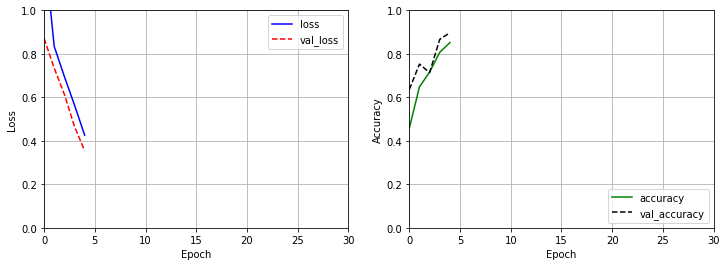

In [23]:
#import matplotlib.pyplot as plt
#%matplotlib inline

# 그림 사이즈 결정하기
plt.figure(figsize=(12,4))

# 손실함수 그래프 그리기 (값이 작을수록 좋음 0.00~1.00 사이)
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.axis([0, 30, 0, 1])
plt.grid()

# 정확도 그래프 그리기 (값이 클수록 좋음 0.00~1.00 사이)
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.7,1)
plt.legend(loc='lower right')
plt.axis([0, 30, 0, 1])
plt.grid()

plt.show()

In [24]:
print('Model Evaluate with Train data')
model.evaluate(img_itr_train)

Model Evaluate with Train data
210/210 [==============================] - 50s 237ms/step - loss: 0.2884 - accuracy: 0.9292


[0.2883985936641693, 0.9291666746139526]

In [25]:
print('Model Evaluate with Validation data')
model.evaluate(img_itr_validation)

Model Evaluate with Validation data
45/45 [==============================] - 11s 234ms/step - loss: 0.3625 - accuracy: 0.9000


[0.3625173270702362, 0.8999999761581421]

In [26]:
print('Model Evaluate with Test data')
model.evaluate(img_itr_test)

Model Evaluate with Test data
8/8 [==============================] - 3s 404ms/step - loss: 0.2574 - accuracy: 0.9333


[0.2573736608028412, 0.9333333373069763]

## 2.4 모델 예측(추론) : 단일 이미지

### 2.4.1 전이학습된 모델을 이용하여 예측할 대상 이미지 준비하기

In [28]:
from tensorflow.keras.preprocessing.image import load_img  

In [29]:
# 구름 분류
class_name=['A - Clear Sky','B - Patterned Cloud','C - Thin White Clouds',
            'D - Thick White Clouds','E - Thick Dark Clouds','F - Veil Clouds']

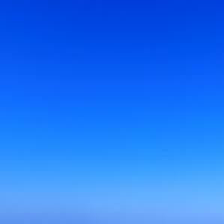

In [30]:
# 클래스 예측 대상 clear sky 이미지 불러오기
img_clear = load_img('./my_own_images/clear_and_cloudy/clear1.jfif', target_size=(224, 224))
img_clear

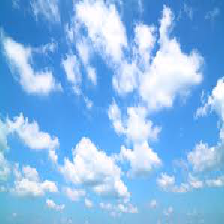

In [31]:
# 클래스 예측 대상 cloud sky 이미지 불러오기
img_cloudy = load_img('./my_own_images/clear_and_cloudy/cloudy1.jfif', target_size=(224, 224))
img_cloudy

In [32]:
from tensorflow.python.keras.preprocessing.image import img_to_array

# 2차원 이미지 데이터를 1차원 배열로 변환하기
arr_clear = img_to_array(img_clear)
arr_cloudy = img_to_array(img_cloudy)
print(arr_clear.shape, arr_cloudy.shape)

(224, 224, 3) (224, 224, 3)


In [33]:
from tensorflow.python.keras.applications.vgg16 import preprocess_input

# 입력 데이터 전처리 (중심화 및 컬러 채널 순서 변경)
arr_clear = preprocess_input(arr_clear)
arr_cloudy = preprocess_input(arr_cloudy)

In [34]:
import numpy as np

# 입력 데이터 결합
arr_input = np.stack([arr_clear, arr_cloudy])

In [35]:
# 입력 데이터 모양 출력 
print('shape of arr_input:', arr_input.shape)

shape of arr_input: (2, 224, 224, 3)


In [36]:
# 입력 데이터 클래스 예측 결과 산출
probs = model.predict(arr_input)

In [37]:
# 예측 결과 모양 출력
print('shape of probs:', probs.shape)

shape of probs: (2, 6)


In [38]:
# 예측 결과 출력
probs

array([[2.9181008e-10, 9.4378057e-24, 1.0000000e+00, 3.5072035e-13,
        2.2556849e-30, 4.4780556e-27],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [39]:
# 예측 결과 출력
probs[0]

array([2.9181008e-10, 9.4378057e-24, 1.0000000e+00, 3.5072035e-13,
       2.2556849e-30, 4.4780556e-27], dtype=float32)

In [40]:
# 예측 결과 출력
probs[1]

array([0., 0., 1., 0., 0., 0.], dtype=float32)

In [41]:
# 예측 결과 출력
print('    Prediction result : ', np.argmax(probs[0]))        

    Prediction result :  2


In [42]:
# 예측 결과 출력
print('    Prediction result : ', np.argmax(probs[1]))       

    Prediction result :  2


    Prediction result :  C - Thin White Clouds


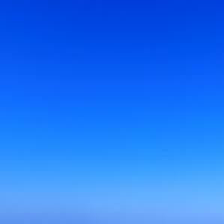

In [43]:
# 예측 결과 출력
print('    Prediction result : ', class_name[np.argmax(probs[0])])
img_clear

    Prediction result :  C - Thin White Clouds


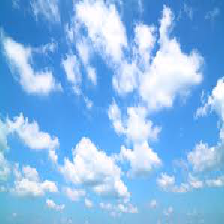

In [44]:
# 예측 결과 출력
print('    Prediction result : ', class_name[np.argmax(probs[1])])
img_cloudy

## 2.5 모델 예측 (추론) : 다중 이미지

### Clear Sky & Clouds Classification

In [45]:
# 사용할 패키지 불러오기

import numpy as np
from numpy import argmax

import glob
from PIL import Image

from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.applications.vgg16 import preprocess_input

In [46]:
test_file = "./my_own_images/clear_and_cloudy/*"
test_filelist = glob.glob(test_file)

In [47]:
for i in range(len(test_filelist)):    # 클래스 예측 대상 이미지 불러오기
    img_test = load_img(test_filelist[i], target_size=(224, 224))
    img_test
    print('Test image number =',i,'    File name : ', test_filelist[i])
   
    # 2차원 이미지 데이터를 1차원 배열로 변환하기
    arr_test = img_to_array(img_test)

    # 입력 데이터 전처리 (중심화 및 컬러 채널 순서 변경)
    arr_test = preprocess_input(arr_test)

    # 입력 데이터 결합
    arr_input = np.stack([arr_test])

    # 입력 데이터 모양 출력 
    #print('STEP = ', i, '   Shape of arr_input:', arr_input.shape)

    # 입력 데이터 클래스 예측 결과 산출
    probs = model.predict(arr_input)

    # 예측 결과 모양 출력
    #print('             Shape of probs:', probs.shape)

    # 예측 결과 출력
    probs  
    print('    Prediction result : ', np.argmax(probs), '  /   Class : ', class_name[np.argmax(probs)])
    print()

Test image number = 0     File name :  ./my_own_images/clear_and_cloudy/cloudy4.jfif
    Prediction result :  2   /   Class :  C - Thin White Clouds

Test image number = 1     File name :  ./my_own_images/clear_and_cloudy/clear3.jfif
    Prediction result :  2   /   Class :  C - Thin White Clouds

Test image number = 2     File name :  ./my_own_images/clear_and_cloudy/cloudy5.jfif
    Prediction result :  2   /   Class :  C - Thin White Clouds

Test image number = 3     File name :  ./my_own_images/clear_and_cloudy/clear4.jfif
    Prediction result :  2   /   Class :  C - Thin White Clouds

Test image number = 4     File name :  ./my_own_images/clear_and_cloudy/cloudy1.jfif
    Prediction result :  2   /   Class :  C - Thin White Clouds

Test image number = 5     File name :  ./my_own_images/clear_and_cloudy/clear1.jfif
    Prediction result :  2   /   Class :  C - Thin White Clouds

Test image number = 6     File name :  ./my_own_images/clear_and_cloudy/clear2.jfif
    Prediction resu

In [48]:
%matplotlib inline

plt.figure(figsize=(5,5))

for i in range(len(test_filelist)):        
    #print(test_filelist[i])
    
    # 이미지 표시
    #plt.subplot(2,5,i+1)    
    plt.show(test_filelist[i])
    # 클래스 표시
    print(i, class_name[np.argmax(probs)])    

<Figure size 360x360 with 0 Axes>

0 C - Thin White Clouds
1 C - Thin White Clouds
2 C - Thin White Clouds
3 C - Thin White Clouds
4 C - Thin White Clouds
5 C - Thin White Clouds
6 C - Thin White Clouds
7 C - Thin White Clouds
8 C - Thin White Clouds
9 C - Thin White Clouds


## END